# Test sur les Gradients en SPDE

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
return false;
}

<IPython.core.display.Javascript object>

In [3]:
import scipy as sc
from scipy.sparse import *
from scipy.sparse.linalg import *
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt

from gstlearn import *
import gstlearn.plot as myplot

Auxiliary function

In [4]:
def fa(x,y,a,b):
    return a*x + b*y

def spirale(db,a=0,b=-1.4,c=1.,d=1.,plot = False):
    x1c = np.array(db.getColumn("x1")) #getColumn ou mieux getCoords coords = workingDb.getCoords()
    x2c = np.array(db.getColumn("x2")) 
    u1=fa(x1c-50,x2c-50,a,b)
    u2=fa(x1c-50,x2c-50,c,d)
    shape = db.getNXs()
    norm = np.sqrt(u1**2+u2**2)
    ind = norm>0
    theta = np.zeros_like(norm)
    theta[norm>0] = np.arccos(u2[ind]/norm[ind])/np.pi*180*np.sign(u1[ind])
    x1c=x1c.reshape(shape)
    x2c=x2c.reshape(shape)
    u1=u1.reshape(shape)
    u2=u2.reshape(shape)
    if plot:
        plt.quiver(x1c,x2c,u1,u2)
        plt.axis("equal")
        plt.show()
    return theta

Draw a vector field

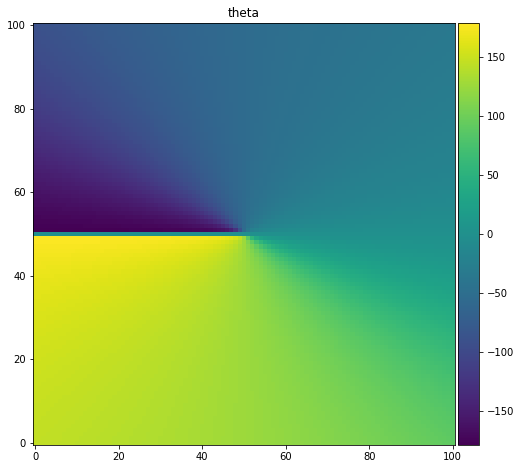

In [5]:
verbose = False

#Création de la grille de représentation
workingDbc = DbGrid.create([10,10],[10,10])
spirale(workingDbc,plot=False);

resultDb = DbGrid.create([101,101],[1,1]) 
x1 = np.array(resultDb.getColumn("x1")) #getColumn ou mieux getCoords coords = workingDb.getCoords()
x2 = np.array(resultDb.getColumn("x2")) 
theta = spirale(resultDb)
Scale1=5*np.ones(theta.size)
Scale2=20*np.ones(theta.size)
iatt = resultDb.addColumns(theta,"theta")
iatt = resultDb.addColumns(Scale1,"Scale1")
iatt = resultDb.addColumns(Scale2,"Scale2")
resultDb.setLocators(['theta','Scale1','Scale2'],ELoc.NOSTAT)

ax = myplot.grid(resultDb,"theta")

Initialize the necessary elements.

In [6]:
# Création de la Base de Données
np.random.seed(124)
ndat=10000
coords=np.random.uniform(1,99,size=(ndat,2))
dat = Db()
dat.addColumns(coords[:,0],"X")
dat.addColumns(coords[:,1],"Y")
dat.setLocators(['X','Y'],ELoc.X)

# Création du modèle. Attention le grand axe doit etre fourni en premier: il correspond à la direction pointée par l'angle 'theta'.
model = Model.createFromParam(gl.ECov.BESSEL_K,param=1,ranges=[40,81],flagRange=False,angles=[30,0.])

NoStat = NoStatArray(["A1"],resultDb)
model.addNoStat(NoStat)

# Création de la grille de travail
workingDb = DbGrid.create([101,101],[1,1]) 
mesh = MeshETurbo(workingDb)

In [7]:
S = ShiftOpCs(mesh, model, resultDb)
err = S.initGradFromMesh(mesh,model)

In [8]:
ind=1051 #indice du vertex

ipar = 1
if ipar == 0 :
    vect = Scale1
    name = "Scale1"
if ipar == 1 :
    vect = Scale2 
    name = "Scale2"
if ipar == 2 :
    vect = theta
    name = "theta"

Btr = csToTriplet(S.getSGrad(ind,ipar))
Bmat=csc_matrix((np.array(Btr.values), (np.array(Btr.rows), np.array(Btr.cols))),
                          shape=(Btr.nrows,Btr.ncols))
#print(Bmat)

In [9]:
uu=Bmat.data

In [10]:
eps=1e-9

thetaaux = vect.copy()
thetaaux[ind]=vect[ind]+eps
resultDb.setColumn(thetaaux,name)
Sp = ShiftOpCs(mesh, model, resultDb)
Smatpt = csToTriplet(Sp.getS())

thetaaux[ind]=vect[ind]-eps
resultDb.setColumn(thetaaux,name)
Sm = ShiftOpCs(mesh, model, resultDb)
Smatmt = csToTriplet(Sm.getS())

indeps = np.abs(np.array(Smatpt.values)-np.array(Smatmt.values))/(2*eps)>1e-3

Smatp=csc_matrix((np.array(Smatpt.values)[indeps], (np.array(Smatpt.rows)[indeps], np.array(Smatpt.cols)[indeps])),shape=(Smatpt.nrows,Smatpt.ncols))
Smatm=csc_matrix((np.array(Smatmt.values)[indeps], (np.array(Smatmt.rows)[indeps], np.array(Smatmt.cols)[indeps])),shape=(Smatmt.nrows,Smatmt.ncols))

A=(Smatp-Smatm)/(2*eps)

#print(A)

In [11]:
v=A.data

In [20]:
Sp

<gstlearn.ShiftOpCs; proxy of <Swig Object of type 'ShiftOpCs *' at 0x7fb2a32271e0> >

ValueError: x and y must be the same size

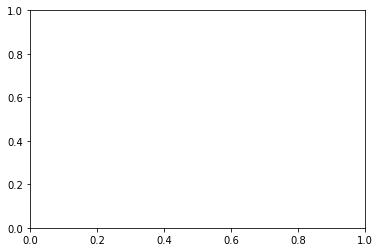

In [13]:
plt.scatter(uu,v)
plt.plot([-2,40],[-2,40])
plt.show()

In [ ]:
S.getLambdaGrads(1)

In [ ]:
thetaaux = vect.copy()
thetaaux[ind]=vect[ind]+eps
resultDb.setColumn(thetaaux,name)
Sp = ShiftOpCs(mesh, model, resultDb)
Lambdap=Sp.getLambdas()

thetaaux = vect.copy()
thetaaux[ind]=vect[ind]-eps
resultDb.setColumn(thetaaux,name)
Sm = ShiftOpCs(mesh, model, resultDb)
Lambdam=Sm.getLambdas()

In [ ]:
eps=1e-8

a=((np.array(Lambdap)-np.array(Lambdam))/(2*eps))[ind]

In [ ]:
#b=S.getLambdaGrad(ipar)[ind]

In [ ]:
print(a)
#print(b)

In [ ]:
#a/b

In [ ]:
#S.initGradFromMesh(mesh,model,resultDb,NoStat)
Q=PrecisionOpCs(S,model.getCova(0),EPowerPT.ONE)

In [ ]:
invect = VectorDouble(Q.getSize())
for i in range(invect.size()):
    invect[i] = np.random.normal(size=(1,))[0]
out = VectorDouble(Q.getSize())
Q.evalDeriv(invect,out,ind,ipar)

In [ ]:
ax = plt.imshow(np.array([i for i in out]).reshape((101,101)))

In [ ]:
X = np.random.normal(size=Q.getSize())
Y = np.random.normal(size=Q.getSize())

In [ ]:
Qp=PrecisionOpCs(Sp,model.getCova(0),EPowerPT.ONE)
Qm=PrecisionOpCs(Sm,model.getCova(0),EPowerPT.ONE)
Qt = csToTriplet(Q.getQ())
Qpt = csToTriplet(Qp.getQ())
Qmt = csToTriplet(Qm.getQ())
Qmat = csc_matrix((np.array(Qt.values), (np.array(Qt.rows), np.array(Qt.cols))),
                    shape=(Qt.nrows,Qt.ncols))
Qpmat = csc_matrix((np.array(Qpt.values), (np.array(Qpt.rows), np.array(Qpt.cols))),
                    shape=(Qpt.nrows,Qpt.ncols))
Qmmat = csc_matrix((np.array(Qmt.values), (np.array(Qmt.rows), np.array(Qmt.cols))),
                    shape=(Qmt.nrows,Qmt.ncols))

In [ ]:
invect = VectorDouble(Q.getSize())
Yvect = VectorDouble(Q.getSize())
invectp = VectorDouble(Qp.getSize())
invectm = VectorDouble(Qp.getSize())
resultp = VectorDouble(Qp.getSize())
resultm = VectorDouble(Qp.getSize())
for i in range(invect.size()):
    invectp[i] = X[i]
    invectm[i] = X[i]
    invect[i] = X[i]
    Yvect[i] = Y[i]
Qp.eval(invectp,resultp)
Qm.eval(invectm,resultm)
aa=(Y.T@resultp - Y.T@resultm)/(2*eps)
aa

In [ ]:
out = VectorDouble(Q.getSize())
Q.evalDeriv(invect,out,ind,ipar)
terme1 = Y.T@out

In [ ]:
u      = np.zeros(shape=Q.getSize())
u[ind] = S.getLambdaGrads(ipar)[ind]
w      = 2*u/S.getLambdas()

In [ ]:
(w*Y)[ind]*(Qmat@X)[ind]

In [ ]:
terme2 = (w*Y).T@Qmat@(X)

In [ ]:
bb=terme1+terme2
aa/bb

In [ ]:
terme2

In [ ]:
result = VectorDouble(Q.getSize() * S.getNModelGradParam())
Q.gradYQX(invect,Yvect,result)

In [ ]:
invect[ind]

In [ ]:
aa/result[S.getSGradAddress(ind,ipar)]

In [ ]:
aa

In [ ]:
bb

In [ ]:
result[S.getSGradAddress(ind,ipar)]
S.getSGradAddress(ind,ipar)

In [ ]:
aa/bb

In [ ]:
terme1